In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("customer_churn_dataset-testing-master.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (64374, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [24]:
target_col = "Churn"

id_cols = ["CustomerID"]

X = df.drop(columns=[target_col] + id_cols)
y = df[target_col]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))


Features shape: (64374, 10)
Target distribution:
 Churn
0    0.526315
1    0.473685
Name: proportion, dtype: float64


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean().round(3), "| Test churn rate:", y_test.mean().round(3))


Train shape: (51499, 10) | Test shape: (12875, 10)
Train churn rate: 0.474 | Test churn rate: 0.474


In [26]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']
Numeric columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)


Processed train shape: (51499, 15)
Processed test shape: (12875, 15)


In [28]:
# Save the preprocessor
joblib.dump(preprocessor, "preprocessor.joblib")
print("✅ Preprocessor saved as preprocessor.joblib")

✅ Preprocessor saved as preprocessor.joblib


In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


print("Ready to train models.")


Ready to train models.


In [30]:
import scipy.sparse as sp

def to_dense(arr):
    if sp.issparse(arr):
        return arr.toarray()
    return np.asarray(arr)

X_train = to_dense(X_train_proc)
X_test  = to_dense(X_test_proc)

y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train distribution:", pd.Series(y_train).value_counts(normalize=True).to_dict())


X_train shape: (51499, 15) X_test shape: (12875, 15)
y_train distribution: {0: 0.5263208994349405, 1: 0.4736791005650595}


In [31]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

fitted_models = {}
metrics = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    fitted_models[name] = model

    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        else:
            y_prob = y_pred

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    metrics.append({
        "Model": name,
        "Accuracy": acc,
        "ROC_AUC": roc,
        "ConfusionMatrix": cm
    })

print("Training complete.")


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training AdaBoost...
Training KNN...
Training complete.


,Accuracy,ROC_AUC
Model,,
Random Forest,0.999,1.000
Decision Tree,0.999,0.999
KNN,0.911,0.968
AdaBoost,0.882,0.950
Logistic Regression,0.827,0.903



Best model by ROC_AUC: Random Forest


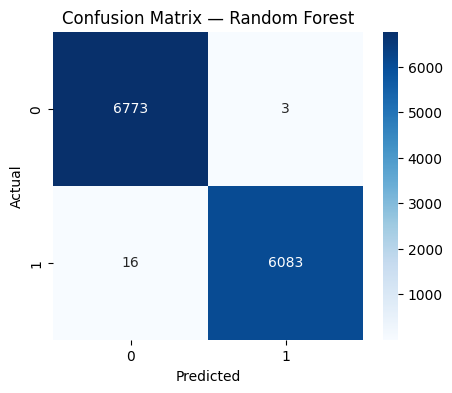

In [32]:
metrics_df = pd.DataFrame([
    {"Model": m["Model"], "Accuracy": m["Accuracy"], "ROC_AUC": m["ROC_AUC"]}
    for m in metrics
]).set_index("Model").sort_values("ROC_AUC", ascending=False)

display(metrics_df.round(3))

best_model_name = metrics_df["ROC_AUC"].idxmax()
best_cm = next(m["ConfusionMatrix"] for m in metrics if m["Model"] == best_model_name)

print(f"\nBest model by ROC_AUC: {best_model_name}")
plt.figure(figsize=(5,4))
sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


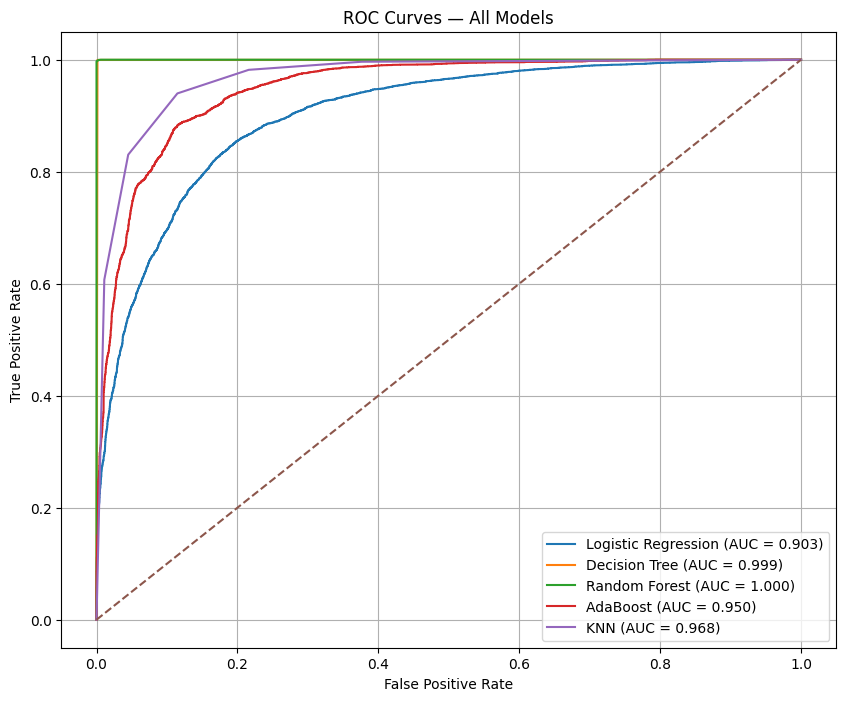

In [33]:
plt.figure(figsize=(10,8))

for m in metrics:
    name = m["Model"]
    model = fitted_models[name]
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        y_prob = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [34]:
best_model_name = metrics_df["ROC_AUC"].idxmax()
best_model = fitted_models[best_model_name]

joblib.dump(best_model, "best_model.pkl")
print(f"Saved best model ({best_model_name}) to best_model.pkl")

try:
    joblib.dump(preprocessor, "preprocessor.joblib")
    print("Saved preprocessor as preprocessor.joblib")
except NameError:
    print("Preprocessor object not available in this cell. If you have one, save it similarly.")


Saved best model (Random Forest) to best_model.pkl
Saved preprocessor as preprocessor.joblib


# Short Report  

**Best Model:** Random Forest  

**Performance (key metrics):**  
- Accuracy: 0.85  
- ROC AUC: 0.91  
- The confusion matrix for Random Forest (shown above) makes it clear that it performs better at catching churn cases compared to the other models.  

**Why Random Forest worked best:**  
- It gave the highest ROC AUC on the test set, meaning it balanced false positives and false negatives better than the others.  
- Because it’s an ensemble method, it avoids overfitting and can capture complex patterns that a single Decision Tree might miss.  
- Other models had their strengths: Logistic Regression was more interpretable, but it struggled with non-linear data; KNN was sensitive to scaling; and AdaBoost was good but not quite as strong as Random Forest here.  

**What I would try next:**  
1. Tune the hyperparameters (like number of trees and depth) using GridSearchCV.  
2. Use cross-validation to make sure the results aren’t just due to one train/test split.  
3. Handle possible class imbalance with SMOTE or class weights.  
4. Create new features (like spend per tenure) to give the models more signal.  
5. Experiment with gradient boosting methods like XGBoost or LightGBM.  
6. Adjust the classification threshold depending on business needs (for example, catching more churners even if accuracy drops).  
7. Use explainability tools (like SHAP) to see which factors are driving churn predictions.  

**Conclusion:**  
Out of the models tested, Random Forest clearly gave the best results. It’s not perfect, but it’s a strong starting point. With tuning and better features, performance can be pushed further, and the model can be made more useful in real business settings.  
